# MPlot tutorial

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'PulsusParadoxus'.

## What is an MPlot?
MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!


**Note**

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed. You can check more examples in [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view). You will also find lots more datasets at his GoogleDrive. [This powerpoint](https://www.slideserve.com/mickie/ucr-time-series-semantic-segmentation-archive-powerpoint-ppt-presentation) explains the content of some of them in a simple way, including the Pulsus Paradoxus dataset.

## Notebook configuration
### Parameters

The parameters in this notebook are only some of the input parameters you can define for the *06-Mplot* notebook. In that notebook the configuration parameters are included in the first cell and fully explained as needed. 

Here you got:

- `verbose`. If `> 0` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `cuda_device`. Integer used to define the GPU machine to be used for computation. Please ensure it is an id number valid for the built docker (check your .env file to know the valid ids)
- `execute_01`. Put this flag to true in case you have never executed the 01_<> notebook for the PulsusParadoxus dataset. Please change it to false one the celss in the section `Execute '1` have already been executed. It does not take very long, but it is some time ;).

In [1]:
#| export
# Configuration paramaters
verbose                       = 1
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1

In [2]:
print("--- Check parameters ---")
print(
    "verbose (for printing or not messages):", verbose, "\n",
    "check_memory_usage (for evaluating the current gpu memor status)", check_memory_usage, "\n",
    "time_flag:", time_flag, "\n",
    "reset_kernel:",reset_kernel, "\n",
    "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
verbose (for printing or not messages): 1 
 check_memory_usage (for evaluating the current gpu memor status) True 
 time_flag: True 
 reset_kernel: False 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [3]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

## Import libraries

In [4]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
warnings.simplefilter('always', UserWarning)
import os
import sys
sys.path.append(os.path.abspath('..'))
import dvats.config as cfg_
import dvats.mplots as mplots
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7f4c24402b60>

















## Generate & Train S3

In [5]:
#-- For setting up the parameters
import os
import torch
from typing import Tuple, Dict

#-- Specific
from ploomber_engine import execute_notebook

##### Ensure the correct configuration for ploomber engine execution

In [6]:
def get_parameters(nb_id : int ) -> Tuple[ str, Dict ]:
    inpath = '~/work/nbs_pipeline'
    outpath = '~/work/nbs_pipeline/output'
    match nb_id:
        case 1:
            filename = "01_dataset_artifact"
            parameters = parameters_01 = {
              'verbose'                       : 0,
              'show_plots'                    : False,
              'reset_kernel'                  : False,
              'pre_configured_case'           : False,
              'case_id'                       : 7,
              'frequency_factor'              : 1,
              'frequency_factor_change_alias' : True,
              'cuda_device'                   : 1 #torch.cuda.current_device()
            }
        case 2: 
            filename   = "02b_encoder_MVP"
            parameters = parameters_02 = {
              'verbose'                       : 0,
              'check_memory_usage'            : False,
              'time_flag'                     : False,
              'window_size_percentage'        : None,
              'show_plots'                    : False,
              'reset_kernel'                  : False,
              'pre_configured_case'           : False,
              'case_id'                       : 7,
              'frequency_factor'              : 1,
              'frequency_factor_change_alias' : True,
              'cuda_device'                   : 1 #torch.cuda.current_device()
            }
        case 10:
            filename   = "_synthetic_data"
            inpath     = "~/work/nbs"
            parameters = {}
            
        case _:
            print("Invalid configuration")
            filename = ""
            inpath = ""
            outpath = ""
            parameters = {}
    return filename,parameters, inpath, outpath

In [7]:
def get_input_output(
    nb_id   : int
) -> Tuple[ str, str, Dict ]:
    filename,parameter, inpath, outpath = get_parameters(nb_id)
    inbpath    = os.path.expanduser(inpath)
    onbpath    = os.path.expanduser(outpath)
    extension  = ".ipynb"
    reportname = filename+"-output"
    inputnb    = inbpath+"/"+filename+extension
    outputnb   = onbpath+"/"+reportname+extension
    print(f"Executing {inputnb} into {outputnb}")
    return parameter, inputnb, outputnb

In [8]:
# Put to true when you need to restore S3 or whatever
generate_S3 = False
execute_01  = False
execute_02  = False

##### Generate S3

In [9]:
if generate_S3:
    parameters, inputnb, outputnb = get_input_output(10)
    print(parameters)
    print(inputnb)
    print(outputnb)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )

##### Execute 01: Load artifact to W&B

In [10]:
if execute_01:
    warnings.simplefilter('ignore', UserWarning)
    parameters, inputnb, outputnb = get_input_output(1)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

##### Execute 02: Train MTSAE

In [11]:
if execute_02:
    warnings.simplefilter('ignore', UserWarning)
    parameters, inputnb, outputnb = get_input_output(2)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

## Initialize and Configurate Artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;The following cells can be skipped as they are configuration cells. Continue until the next warning.
    </div>
</div>

### Initialize Weights and Biases

In [12]:
#| export
wandb_api = wandb.Api()

### Setup CUDA

In [13]:
#| export
warnings.filterwarnings("ignore", module="wandb")
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 8
GPU | Used mem: 48
GPU | Memory Usage: [███-----------------] 17%


### Get configutation from yml
> This file used the configuration files './config/base.yml'

In [14]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


In [15]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

### Setup Weights & biases artiffact

In [16]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_S3"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

runname: _MPlot_S3
alias: S3
analysis_mode: online
batch_size: 32
epochs: 200
mask_future: True
mask_stateful: False
mask_sync: False
mvp_ws: (32, 96)
norm_by_sample: False
norm_use_single_batch: False
r: 0.4
stride: 1
train_artifact: mi-santamaria/deepvats/S3:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 96
wandb_group: None


In [17]:
job_type = 'MPlot'
job_type

'MPlot'

## Start W&B Run

In [18]:
#| export
if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

--> Wandb init


wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;End of the skippable cells.
    </div>
</div>

## Get the time series data
### Get W&B train artifact

In [19]:
#| export
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")

alias: S3
analysis_mode: online
batch_size: 32
epochs: 200
mask_future: True
mask_stateful: False
mask_sync: False
mvp_ws: [32, 96]
norm_by_sample: False
norm_use_single_batch: False
r: 0.4
stride: 1
train_artifact: mi-santamaria/deepvats/S3:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 96
wandb_group: None
---> W&B Train Artifact


### Transform to dataframe

In [20]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [21]:
#| export
if verbose > 0: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(1920, 1)


<bound method NDFrame.head of                      Seasonal time series w/ noise and trend
2022-03-01 00:00:00                               -19.154111
2022-03-01 00:15:00                               -18.105373
2022-03-01 00:30:00                               -15.033257
2022-03-01 00:45:00                               -13.274748
2022-03-01 01:00:00                               -12.909683
...                                                      ...
2022-03-20 22:45:00                                26.430450
2022-03-20 23:00:00                                30.074363
2022-03-20 23:15:00                                30.027896
2022-03-20 23:30:00                                33.542406
2022-03-20 23:45:00                                37.703090

[1920 rows x 1 columns]>

df_train ~  (1920, 1)
window_sizes =  [32, 96]
wlen =  96


## Check the MatrixProfile

In [22]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1
GPU | Used mem: 8
GPU | Used mem: 48
GPU | Memory Usage: [███-----------------] 17%


### Initialize parameters

In [23]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = dvats.mplots.scamp.gpu_supported()
has_gpu_support

True

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

### Get the time series data

In [24]:
# Use step for selecting values in position k*step 
ts_step = 1
ts_resampled = df_train.resample('15T').mean()
ts_resampled = ts_resampled.fillna(0)
ts = ts_resampled.iloc[:, 0].values
ts

array([-19.15411105, -18.10537267, -15.03325693, ...,  30.02789551,
        33.54240642,  37.70308966])

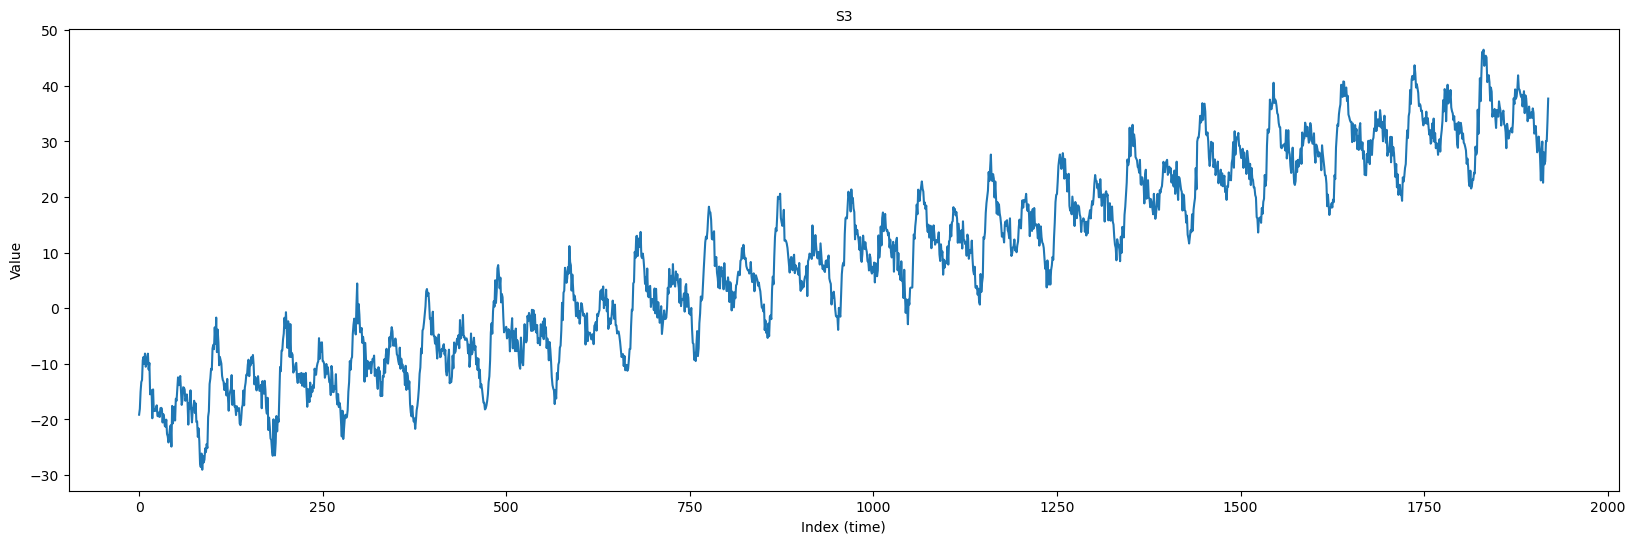

In [25]:
%matplotlib inline
plt.close("all")
mplots.plot_with_dots(
    time_series = ts, 
    title = "S3", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (20,6)
)

### Build the MatrixProfile object

In [26]:
pulsus_mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

In [27]:
print(len(ts))
x = len(ts)/20
print(x)


1920
96.0


### Choose window length
Eamon et all use ''approximately 1 pulsus'': m = 50. 
Let's see what does Fourier transform detect

In [28]:
pulsus_mp.provide_lens(1)
pulsus_mp.dominant_lens

[24]

In [29]:
m = 96 #pulsus_mp.dominant_lens[0]

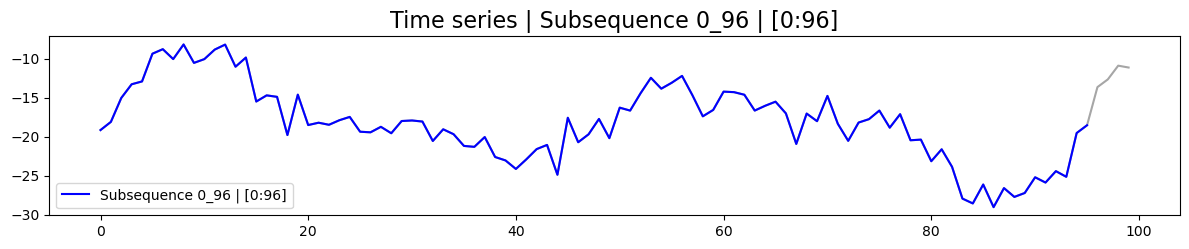

In [30]:
mplots.plot_subsequence(
    TA = ts[:100], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

And what happens if we use the double?

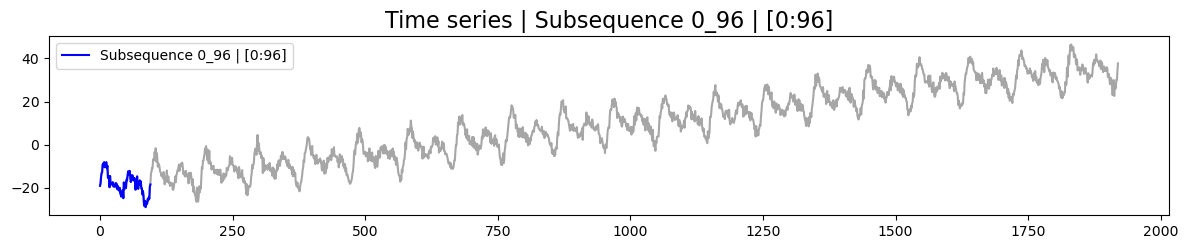

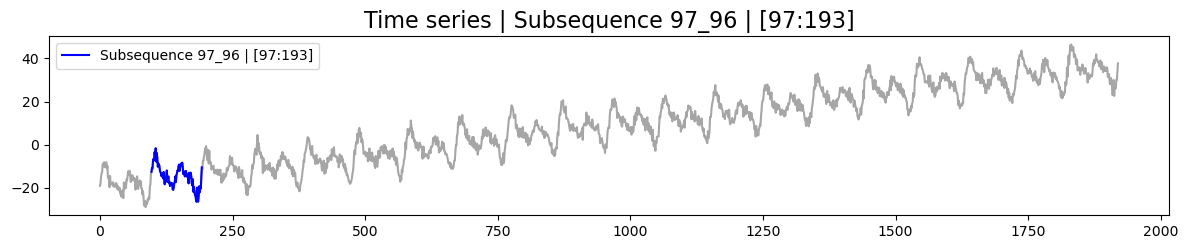

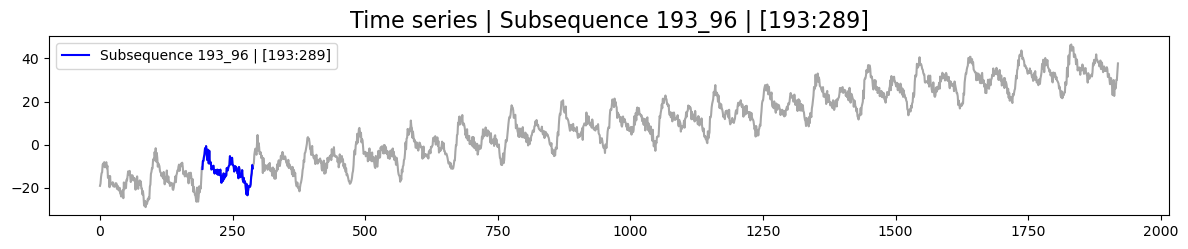

In [31]:
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 2*m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

This value seems to correspond to that idea of getting 'one pulsus' as subsequence length

### Compute the Matrix Profile

In [32]:
pulsus_mp.subsequence_len = m

In [33]:
pulsus_mp.compute(
    verbose = 1, 
    d = mplots.z_normalized_euclidean_distance, 
    method = 'stump'
)

[ Matrix Profile ] Compute | subsequence_len: 96
--> matrix profile
--> Stump (CPU)
MP | Compute | Using stumpy.stump | normalize? True
matrix profile 31.19864010810852 seconds -->


array([3.8915685805560147, 3.8889766119258717, 3.8523620757468993, ...,
       3.5711088713837684, 3.5712085387426593, 3.557992054178591],
      dtype=object)

In [34]:
len(pulsus_mp.index)

1825

### Visualization of the matrix profile

With the interactive plot we can visually check the motif and anomaly indexes.
The previous and next buttons can be used for going subsequence by subsequence whereas the Motif and Discord buttons show the associated subsequences.

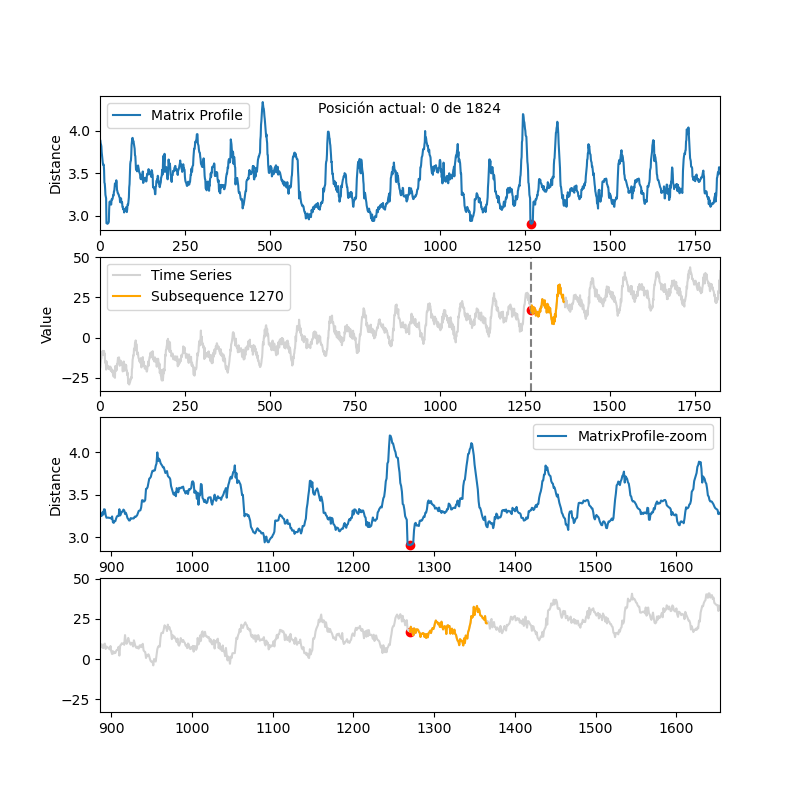

In [35]:
%matplotlib widget
pulsus_mp.plot_interactive(
    figsize = (8,8),
    verbose =  0
)

### Direct computation & related metadata

#### Motif

In [36]:
pulsus_mp.get_motif_idx(verbose = verbose)

motif id 1270 index ~  1825


(1270, 22, 22, 1463)

In [37]:
print(pulsus_mp.motif_idx)
print(pulsus_mp.motif_nearest_neighbor_idx)
print(pulsus_mp.motif_nearest_neighbor_idx_left)
print(pulsus_mp.motif_nearest_neighbor_idx_right)


1270
22
22
1463


#### Discord/Anomaly

In [38]:
pulsus_mp.get_anomaly_idx(verbose = verbose)

motif id 479 index ~  1825
Nearest  383
Nearest left  383
Nearest right  575


(479, 383, 383, 575)

In [39]:
print(pulsus_mp.discord_idx)
print(pulsus_mp.discord_nearest_neighbor_idx)
print(pulsus_mp.discord_nearest_neighbor_idx_left)
print(pulsus_mp.discord_nearest_neighbor_idx_right)

479
383
383
575


## Check the MPlot

### Build the MatrixProfilePlot object

In [40]:
data_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [41]:
#| hide
print("MP_AB self_join", data_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {data_MPlot.DM_AB.shape}")
print("MP_AB method:", data_MPlot.MP_AB.method)
print("DM_AB method:", data_MPlot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


### Compute the Similarity Matrix

In [42]:
data_MPlot.subsequence_len

96

In [43]:
# z-normalized euclidean distance
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import correlation
from scipy.spatial.distance import cityblock
def zeuclidean(u,v): return euclidean(zscore(u), zscore(v));
def distance(u,v):
    #-- euclidean
    #return euclidean(u,v)
    #-- z_normalized euclidean
    #return zeuclidean(u,v)
    #-- Pearson correlation
    #return correlation(u,v)
    return cityblock(u,v)

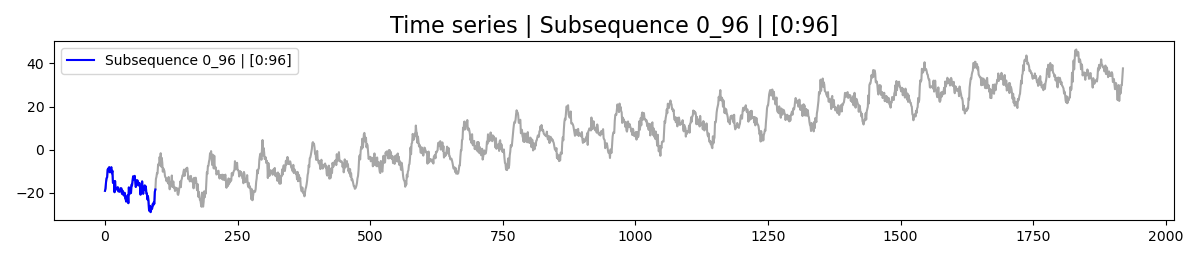

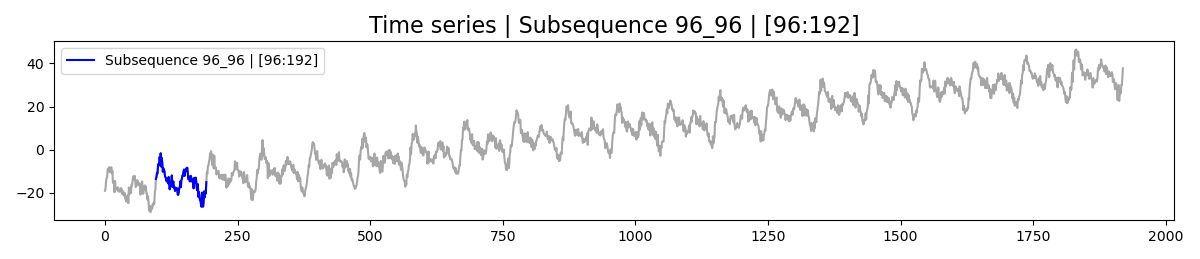

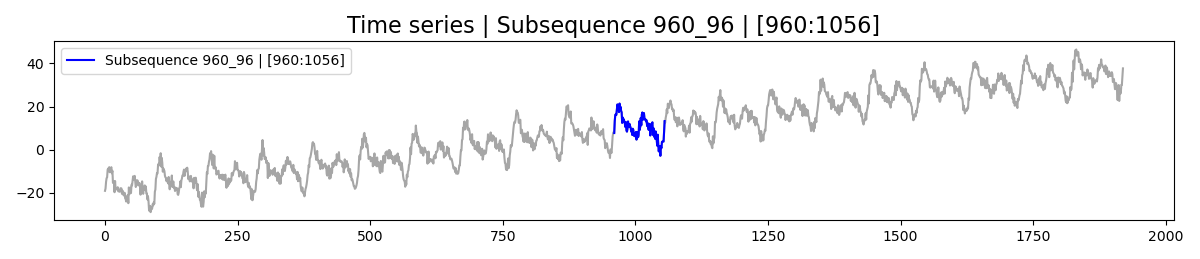

In [44]:
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = m,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts, 
    sequence_i = 10*m,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

In [45]:
print(euclidean(ts[0:m], ts[m:m+m]))
print(euclidean(ts[m:m+m], ts[10*m:10*m+m]))
print(euclidean(ts[0:m], ts[10*m:10*m+m]))

39.70122568000471
247.5591311368893
281.1210772830895


In [46]:
print(zeuclidean(ts[0:m], ts[m:m+m]))
print(zeuclidean(ts[m:m+m], ts[10*m:10*m+m]))
print(zeuclidean(ts[0:m], ts[10*m:10*m+m]))

4.123400114993083
4.895342976008982
4.604438228357251


In [47]:
print(correlation(ts[0:m], ts[m:m+m]))
print(correlation(ts[m:m+m], ts[10*m:10*m+m]))
print(correlation(ts[0:m], ts[10*m:10*m+m]))

0.08855431514752587
0.12481449402479405
0.11042110103519587


In [48]:
print(cityblock(ts[0:m], ts[m:m+m]))
print(cityblock(ts[m:m+m], ts[10*m:10*m+m]))
print(cityblock(ts[0:m], ts[10*m:10*m+m]))

335.63370715285225
2413.0108176341364
2745.0029580926835


Para tendencias parece que mejor la euclidiana o la correlation

z-euclidean mata las tendencias
SCAMP no permite modificar la ditancia
Probando con:
- stump y euclidean
- Naive y distancia manhattan (cityblock)
- Naive y distancia específica

In [49]:
data_MPlot.compute(
    mp_method           = 'stump', 
    dm_method           = 'stump',
    d                   = euclidean,
    #dm_method           = 'scamp',
    #d                   = z_normalized_euclidean_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)

Not parallel
[] Start: 1732223994.9611824 | End: 1732223995.904157 | Duration: 0.9429745674133301 seconds
matrix profile 0.9429745674133301 seconds -->
[compute] Start: 1732223980.8919954 | End: 1732223995.9089208 | Duration: 15.01692533493042 seconds


### Check the obtained values

In [50]:
print(data_MPlot.subsequence_len)

96


In [51]:
n_a = len(data_MPlot.data)
n_b = len(data_MPlot.data_b)
print("-- DM Expected dimensions -- ")
print("Rows: ", n_b - data_MPlot.subsequence_len + 1)
print("Columns: ", n_a - data_MPlot.subsequence_len + 1)
print(f"-- Obtained shape when computing using  {data_MPlot.DM_AB.method} --")
print(data_MPlot.DM_AB.shape)
print(f"-- MP dimension using {data_MPlot.MP_AB.method}")
print(len(data_MPlot.MP_AB.distances))
print("-- DM Values --")
print(data_MPlot.DM_AB.distances)
print("-- MP values --")
print(data_MPlot.MP_AB.distances)

-- DM Expected dimensions -- 
Rows:  1825
Columns:  1825
-- Obtained shape when computing using  stump --
(1825, 1825)
-- MP dimension using stump
1825
-- DM Values --
[[  0.          22.96318694  26.62009189 ... 523.64698209 524.02513337
  524.23334354]
 [         inf          inf          inf ... 523.3364677  523.63766758
  523.66912541]
 [         inf          inf          inf ... 523.2327791  523.33232967
  523.29385873]
 ...
 [523.64698209 523.3364677  523.2327791  ...          inf          inf
           inf]
 [524.02513337 523.63766758 523.33232967 ...          inf          inf
           inf]
 [524.23334354 523.66912541 523.29385873 ...          inf          inf
           inf]]
-- MP values --
[39.70122568000471 39.43607248958635 39.07836183835571 ...
 31.813775852668122 32.25211750573863 32.099974341301355]


### Visualize the plot

##### Motif found by MP

Motif found using MP
1571
Plotted: ts[1475,1763] => 1571 subsequence index changes to 96


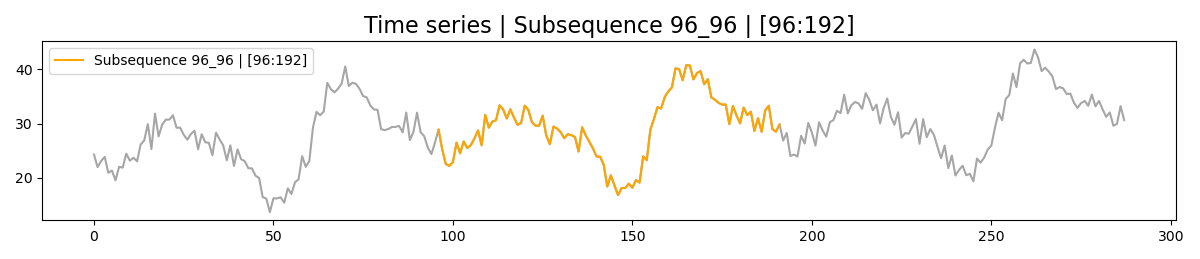

In [52]:
print("Motif found using MP")
data_MPlot.MP_AB.get_motif_idx()
print(data_MPlot.MP_AB.motif_idx)

init = data_MPlot.MP_AB.motif_idx - m
final = init+3*m
print(f"Plotted: ts[{init},{final}] => {data_MPlot.MP_AB.motif_idx} subsequence index changes to {data_MPlot.MP_AB.motif_idx-init}")

mplots.plot_subsequence(
    TA = ts[init:final],
    sequence_i = data_MPlot.MP_AB.motif_idx-init,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    color = "orange"
)


Before: Pos 0 Add 0
Plot Interactive | After: Pos 0 Selected index 1571
Plot Interactive | Distances:  [39.70122568000471 39.43607248958635 39.07836183835571 ...
 31.813775852668122 32.25211750573863 32.099974341301355]
Plot Interactive | Window [71, 1825]


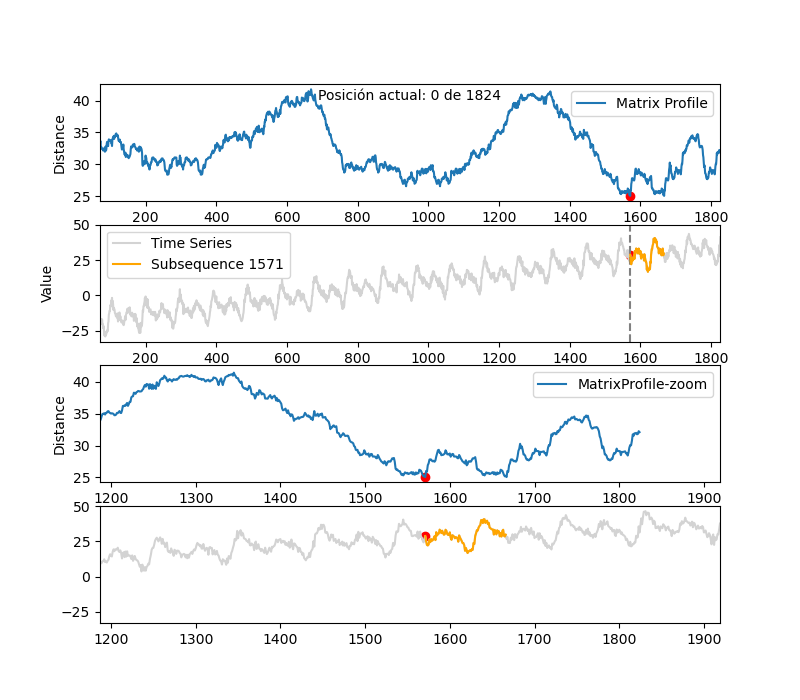

In [53]:
%matplotlib widget
# Max points to plot
data_MPlot.MP_AB.max_points = 3000
data_MPlot.MP_AB.plot_interactive(verbose = 1, figsize=(8,7))

#### Setting up a threshold

It has been checked that, at least for pulsus raxodus, STUMP separates more the distances than SCAMP, so the proposed thresholds show similar plots for the specific case.

In [54]:
# Threshold per method
threshold_scamp = 10
threshold_stump = 7.5
# Select the threshold for the method used for the computation
threshold = threshold_stump if data_MPlot.DM_AB.method == 'stump' else threshold_scamp

#### Visualizing the MPlot in gray scale

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;TODO: check, the gray_color flag is in the opposite way... 
    </div>
</div>

- El patrón es el mismo, cada vez un poco más para arriba
- Eso significa que la distancia debe ser cada vez un poco mayor entre unos y otros (en este caso de manera constante)
- Si miro una fila/columna de la matriz de similitud, debería ser cada número (saltando de m en m) un poco mayor que el siguiente
- En los colores se debería ver cada vez más distancia entre unos y otros. 

In [55]:
print(data_MPlot.DM_AB.distances[0][0:m+1])
print(data_MPlot.DM_AB.distances[0][m:2*m+1])
total = len(data_MPlot.DM_AB.distances[0])
print(data_MPlot.DM_AB.distances[0][total:total-m+1])


[ 0.         22.96318694 26.62009189 33.16260269 39.44598892 45.28047726
 51.9076387  57.49946312 63.20359124 68.05698573 74.40345986 78.15858499
 82.73705705 85.45676491 87.77719827 89.46531235 91.33173257 92.31673247
 93.25502479 93.88298147 93.92010185 94.13124737 94.09668251 93.58458676
 93.67325893 93.31560269 92.52280801 93.12945842 92.22315983 91.73620353
 91.32300805 90.30046164 89.4892825  88.44862339 86.70690479 85.1667797
 83.38288398 80.74772594 78.70938902 74.97276491 71.92082109 69.00398819
 65.52635649 62.89865888 59.90798902 57.57356418 55.87142546 54.68501429
 54.30771356 54.61370526 56.20108561 58.08996244 61.56223369 65.2624089
 68.07759308 70.93635985 74.78442793 77.65509202 80.46178946 83.9274124
 86.34123978 89.26717661 90.77944004 91.90257119 93.07807431 93.59026439
 94.66685712 95.37459248 95.98372946 96.67791605 96.785476   96.89135204
 97.17624463 97.37965092 97.32464623 97.75788393 97.71423089 97.72792015
 96.93942017 96.26304245 95.00017107 92.9340992  91.64

Threshold: 7.5 | Mehod: stump


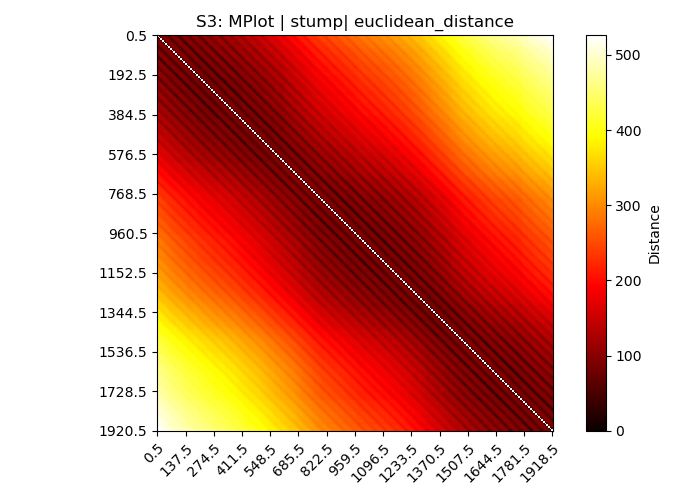

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [75]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = f'S3: MPlot | {data_MPlot.DM_AB.method}| euclidean_distance',
    plot_mp_flag= False,
    gray_color  = False,
    verbose     = 0,
    plot_name   = f'example_s3_mplot_{data_MPlot.DM_AB.method}_euclidean distance',
    save_plot   = True,
    plot_format = 'svg',
    plot_path   = "./images"
)

In [ ]:
data_MPlot.compute(
    mp_method           = 'stump', 
    dm_method           = 'scamp',
    d                   = z_normalized_euclidean_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = f'S3: MPlot | {data_MPlot.DM_AB.method}| z-normalized euclidean_distance',
    plot_mp_flag= False,
    gray_color  = False,
    verbose     = 0,
    plot_name   = f'example_s3_mplot_{data_MPlot.DM_AB.method}_znormalized_euclidean_distance',
    save_plot   = True,
    plot_format = 'svg',
    plot_path   = "./images"
)

#### Tratando de definir una distancia buena para ver tendencias

##### CityBlock

In [57]:
def manhattan(
    vector_a    = np.array([0]),
    vector_b    = np.array([0]), 
    verbose     = 0,
    time_flag   = False
):
    t = 0
    if time_flag: 
        timer = dvats.utils.Time()
        timer.start()
        
    if verbose > 0: 
        print(f"Vectors: a: {vector_a} b: {vector_b}")
    distance = cityblock(vector_a, vector_b)
    if time_flag:
        timer.end()
        t = timer.duration()
    return distance, t

In [58]:
data_MPlot_trend_manhattan = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

##### Trying to be able to detect both up and down trends

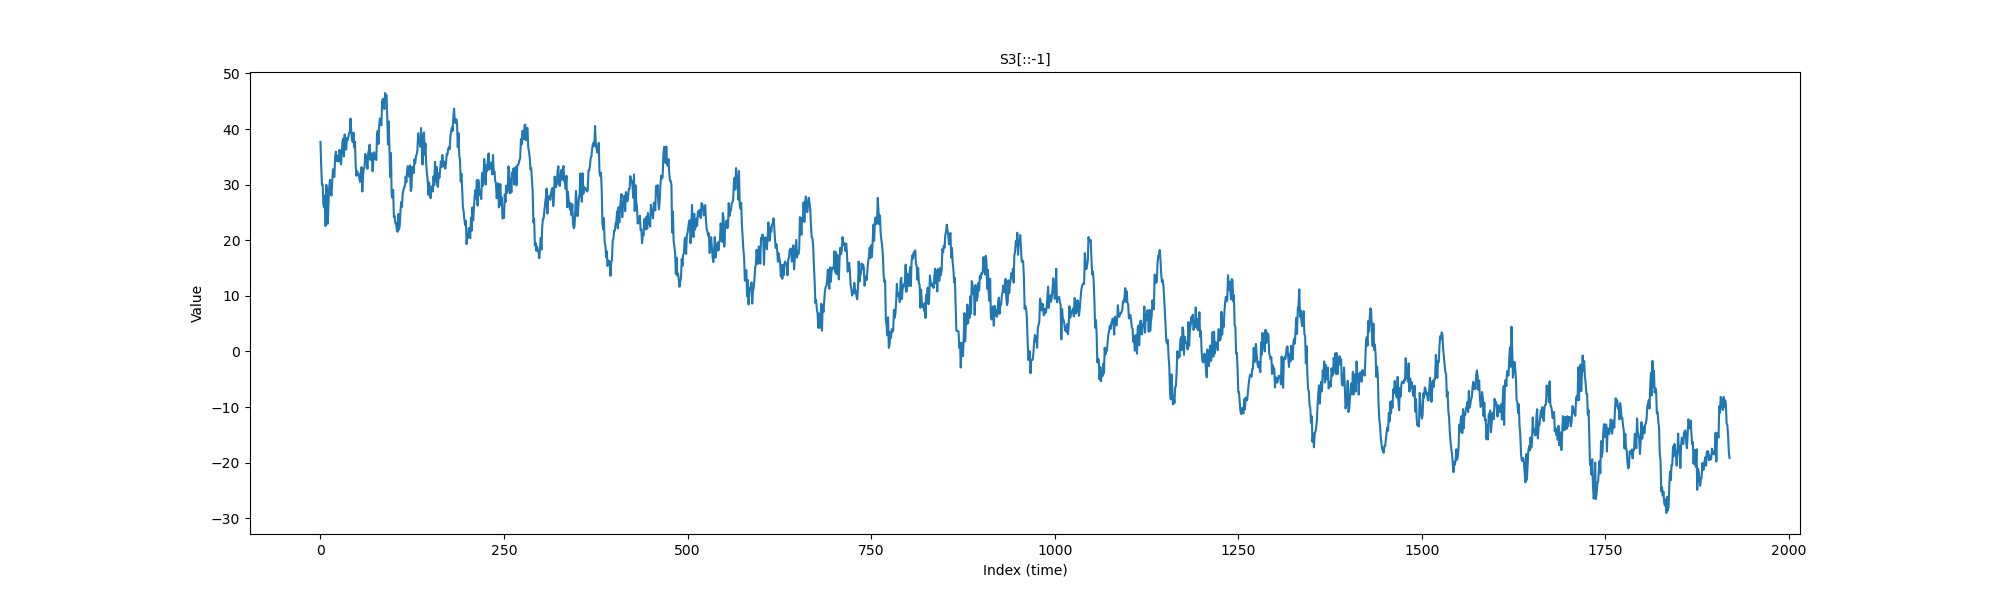

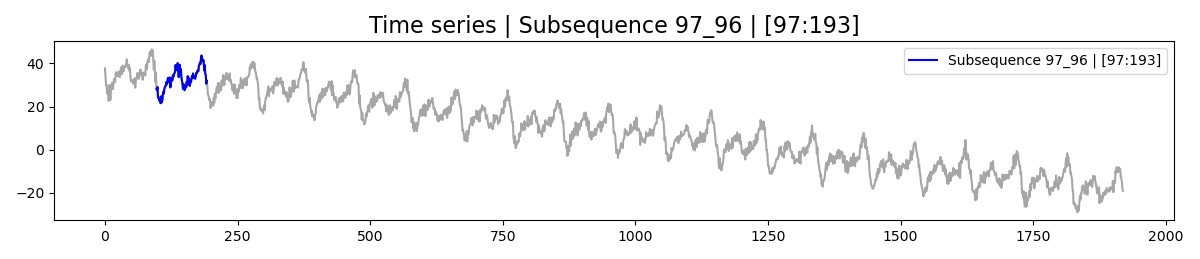

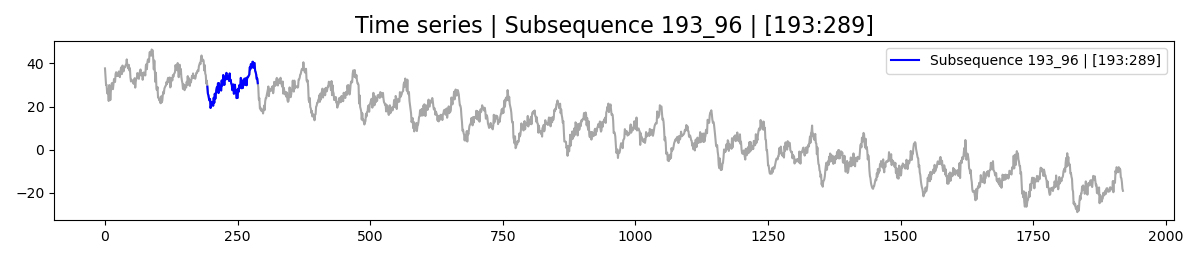

In [59]:
plt.close("all")
mplots.plot_with_dots(
    time_series = ts[::-1], 
    title = "S3[::-1]", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (20,6)
)
mplots.plot_subsequence(
    TA = ts[::-1], 
    sequence_i = m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[::-1], 
    sequence_i = 2*m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

In [60]:
ts_ = ts[::-1]
print("Euclidean")
print(euclidean(ts_[0:m], ts_[m:m+m]))
print(euclidean(ts_[m:m+m], ts_[10*m:10*m+m]))
print(euclidean(ts_[0:m], ts_[10*m:10*m+m]))

Euclidean
32.09997434130135
242.84623180716378
266.9897766600091


In [61]:
def height_distance(#The no-distance with sign
    vector_a    = np.array([0]),
    vector_b    = np.array([0]),
    verbose     = 0,
    time_flag   = False
): 
    t = 0
    if time_flag:
        timer = dvats.utils.Time()
        timer.start()
    if verbose > 0:
        print(f"Vectors: a: {vector_a} b: {vector_b}")
    mean_u      = vector_a.mean()
    mean_v      = vector_b.mean()
    no_distance = mean_u -mean_v
    if time_flag: 
        timer.end()
        t = timer.duration()
    return no_distance, t

In [62]:
print("Height TS_")
print(height_distance(vector_a = ts_[0:m], vector_b = ts_[m:m+m], verbose = 1, time_flag = True))
print(height_distance(ts_[m:m+m], ts_[10*m:10*m+m]))
print(height_distance(ts_[0:m], ts_[10*m:10*m+m]))

Height TS_
Vectors: a: [37.70308966 33.54240642 30.02789551 30.07436306 26.43044988 25.88364675
 28.04538993 22.57104601 29.97230347 28.24703939 22.97901664 26.85730881
 29.71118013 30.86942408 28.77561054 28.04500469 30.39396008 32.77422149
 31.57569391 31.40153903 35.11307113 35.93624815 34.24446293 35.23296983
 34.33264748 34.1915041  36.26479886 34.85910195 33.63110646 35.86045838
 37.784859   38.27983212 35.08599441 39.03243156 37.36884028 36.30356448
 38.39687794 38.02633915 38.57065102 39.29653589 39.4280827  41.8845435
 39.41666267 38.08489181 37.66856383 39.35635762 36.71819418 37.73861079
 33.45908175 31.60362371 32.43952277 31.95524286 31.93687277 31.12366583
 30.51234421 32.12929645 33.16139499 28.77808509 31.66460404 32.90406137
 33.06356849 35.53244842 35.11415113 34.22135399 32.86232146 35.56239483
 36.25557245 37.20282621 34.4520925  35.01694662 35.65628251 32.41904252
 34.31832957 35.83933706 34.6693918  35.33480068 34.43721302 38.94828708
 39.67947573 37.32097228 40.6

In [63]:
print("Height TS")
print(height_distance(ts[0:m], ts[m:m+m]))
print(height_distance(ts[m:m+m], ts[10*m:10*m+m]))
print(height_distance(ts[0:m], ts[10*m:10*m+m]))

Height TS
(-3.458251463109864, 0)
(-25.13552935035559, 0)
(-28.593780813465454, 0)


In [64]:
data_MPlot_trend = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [65]:
data_MPlot_trend.compute(
    mp_method           = 'stump', 
    dm_method           = 'naive',
    d                   = height_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)

[] Start: 1732224000.5927773 | End: 1732224072.6715715 | Duration: 72.07879424095154 seconds
matrix profile 72.07879424095154 seconds -->
[compute] Start: 1732224000.5483384 | End: 1732224072.6764257 | Duration: 72.12808728218079 seconds


In [66]:
data_MPlot_trend.DM_AB.distances

array([[  0.        ,   0.05743274,   0.11427796, ...,  53.38069528,
         53.43705239,  53.45790032],
       [         inf,          inf,          inf, ...,  53.32326255,
         53.37961965,  53.40046758],
       [         inf,          inf,          inf, ...,  53.26641732,
         53.32277442,  53.34362235],
       ...,
       [-53.38069528, -53.32326255, -53.26641732, ...,          inf,
                 inf,          inf],
       [-53.43705239, -53.37961965, -53.32277442, ...,          inf,
                 inf,          inf],
       [-53.45790032, -53.40046758, -53.34362235, ...,          inf,
                 inf,          inf]])

Threshold: 7.5 | Mehod: stump
r_start 0
r_end 1920
c_start 0
c_end 1920
nr 1921
nc 1921
Plotting as MATLAB
Saving s3_mplot_stump+height_distance to ./images


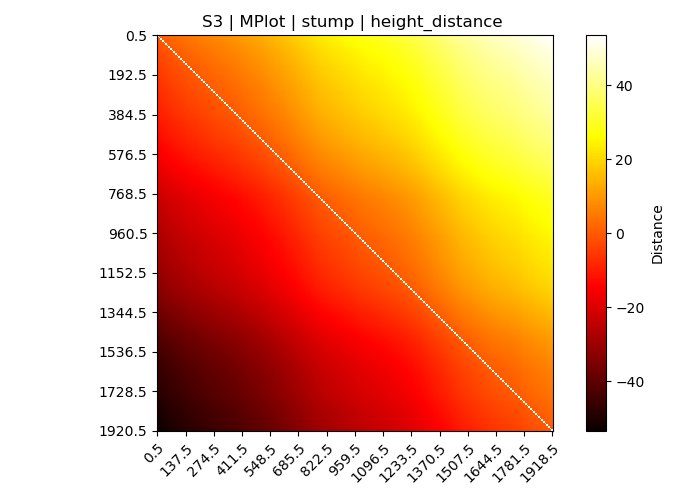

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [73]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot_trend.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3 | MPlot | ' + data_MPlot.DM_AB.method + ' | height_distance ',
    plot_mp_flag= False,
    gray_color  = False,
    verbose     = 1,
    save_plot   = True,
    plot_name   = f's3_mplot_{data_MPlot.DM_AB.method}+height_distance',
    show_flag   = True,
    plot_path   = "./images"
)

Comprobando tendencia a la baja

In [68]:
data_MPlot_trend_down = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts[::-1], 
    data_b          = ts[::-1],
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [69]:
data_MPlot_trend_down.compute(
    mp_method           = 'stump', 
    dm_method           = 'naive',
    d                   = height_distance,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 4,
    verbose             = 0,
    threads             = 1,
    gpus                = [1]
)

[] Start: 1732224074.379805 | End: 1732224126.895106 | Duration: 52.515300989151 seconds
matrix profile 52.515300989151 seconds -->
[compute] Start: 1732224074.3365781 | End: 1732224126.9010408 | Duration: 52.564462661743164 seconds


In [70]:
data_MPlot_trend_down.DM_AB.distances

array([[ 0.00000000e+00, -2.08479301e-02, -7.72050346e-02, ...,
        -5.33436224e+01, -5.34004676e+01, -5.34579003e+01],
       [            inf,             inf,             inf, ...,
        -5.33227744e+01, -5.33796196e+01, -5.34370524e+01],
       [            inf,             inf,             inf, ...,
        -5.32664173e+01, -5.33232625e+01, -5.33806953e+01],
       ...,
       [ 5.33436224e+01,  5.33227744e+01,  5.32664173e+01, ...,
                    inf,             inf,             inf],
       [ 5.34004676e+01,  5.33796196e+01,  5.33232625e+01, ...,
                    inf,             inf,             inf],
       [ 5.34579003e+01,  5.34370524e+01,  5.33806953e+01, ...,
                    inf,             inf,             inf]])

Threshold: 7.5 | Mehod: stump


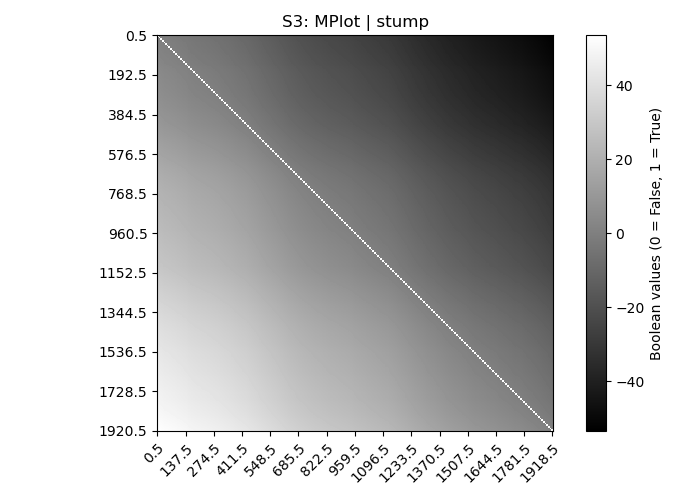

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [71]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot_trend_down.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    verbose     = 0,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = -np.inf,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3: MPlot | ' + data_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

In [72]:
run.finish()
if reset_kernel:
    os._exit(00)